<a href="https://colab.research.google.com/github/nuneslg/MLP_CNN/blob/main/MLP_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IF867 - Introdução à Aprendizagem Profunda
## 1ª atividade prática - 2025.1

- Discente(s): Luís Guilherme Monteiro Maciel Nunes (lgmmn)

## Instruções e requisitos
- Objetivo: Implementar e treinar um Multi-Layer Perceptron e uma Rede Neural Convolucional, inteiramente em PyTorch.
- Observação: A atividade pode ser feita em dupla.

## Tarefas

1. Multi-Layer Perceptron (MLP) para Regressão (50% da nota):
  - Implementação: Construa um MLP funcional para uma tarefa de regressão.
  - Experimentação:
      - Varie a arquitetura da rede (ex: número de camadas, neurônios por camada).
      - Teste diferentes otimizadores (ex: Adam, SGD).
      - Explore outras modificações que julgar pertinentes.
  - Relatório: Documente no notebook os experimentos realizados, as configurações utilizadas e os resultados obtidos, analisando o impacto de cada alteração.
- Rede Neural Convolucional (CNN) (50% da nota):
  - Implementação: Proponha e construa sua própria arquitetura de CNN.
  - Implemente funções para o treinamento e avaliação do modelo.
  - Métricas e Análise:
    - Registre o tempo de treinamento de cada configuração.
    - Gere e apresente a matriz de confusão para os resultados da classificação.
    - Plote gráficos da função de loss e da acurácia ao longo das épocas de treinamento.
  - Experimentação:
    - Aplique e avalie técnicas de regularização (ex: Dropout, Batch Normalization).
    - Implemente e analise o Grad-CAM para visualização e interpretabilidade.
    - Explore outras técnicas relevantes para otimização ou análise de CNNs.
  - Relatório: Documente no notebook os experimentos realizados, as configurações utilizadas e os resultados obtidos, analisando o impacto de cada alteração.


## Datasets recomendados:
Aqui estão alguns datasets recomendados, mas fica a cargo do aluno escolher os datasets que utilizará na atividade, podendo escolher um dataset não listado abaixo.

### Regressão
|Nome |Link |
|-----|-----|
|Air Quality | https://archive.ics.uci.edu/dataset/360/air+quality |
|Student Performance | https://archive.ics.uci.edu/dataset/320/student+performance |
|Wine Quality | https://archive.ics.uci.edu/dataset/186/wine+quality |


### Classificação
|Nome |Link |
|---|---|
|CIFAR10|https://docs.pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html|
|FashionMNIST| https://docs.pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST|
|Stanford Cars| https://docs.pytorch.org/vision/main/generated/torchvision.datasets.StanfordCars.html#torchvision.datasets.StanfordCars|

# MLP

### Configuração Geral

- Python 3.9  
- PyTorch 2.0.1  
- scikit‑learn 1.2.2  
- ucimlrepo 0.1.0  
- Device: `cuda` se disponível, senão `cpu`  
- Seed: 42

In [ ]:
!pip install ucimlrepo
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 21.4 MB/s eta 0:00:00


In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random
import numpy as np
import optuna
import torch.nn.functional as F

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Carregamento e Pré‑processamento
- Dataset: Wine Quality (UCI, id=186) via `ucimlrepo`  
- Variáveis de entrada: 11 atributos fisico‑químicos  
- Alvo: qualidade do vinho (valor de 0–10)  
- Normalização: `StandardScaler` em X e y  
- Split: 80% treino, 20% teste  


In [ ]:
# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets

# metadata
print(wine_quality.metadata)

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [ ]:
# normalizar
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [ ]:
# Setup
input_dim = X_train.shape[1]
criterion = nn.MSELoss()

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

### Modelo

- Camadas ocultas: lista `hidden_layers`  
- Ativação: ReLU  
- Saída: 1 neurônio, regressão  

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim=1, activation=nn.ReLU, dropout_rate=None, use_batchnorm=False):
        """
        input_dim: num features
        hidden_layers: size das camadas ocultas
        output_dim: size da camada de saída (regressão = 1)
        activation: função de ativação
        dropout_rate: taxa de dropout
        """
        super().__init__()
        layers = []
        current_dim = input_dim

        for h in hidden_layers:
            layers.append(nn.Linear(current_dim, h))
            layers.append(activation())
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            if dropout_rate and dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            current_dim = h

        layers.append(nn.Linear(current_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


### Optuna

In [ ]:
activation_map = {
  "ReLU": nn.ReLU,
  "Tanh": nn.Tanh,
  "Sigmoid": nn.Sigmoid,
  "LeakyReLU": nn.LeakyReLU,
  "ELU": nn.ELU
}

In [ ]:
def objective(trial):

    # Sugerir hiperparâmetros
    n_layers = trial.suggest_int("n_layers", 1, 4)
    hidden_layers = [trial.suggest_int(f"n_units_l{i}", 16, 512, log=True) for i in range(n_layers)]
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    activation_name = trial.suggest_categorical("activation", list(activation_map.keys()))
    activation_fn = activation_map[activation_name]
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)


    model = MLP(
        input_dim=input_dim,
        hidden_layers=hidden_layers,
        output_dim=1,
        activation=activation_fn,
        dropout_rate=dropout_rate,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    epochs = 50
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_output = model(X_test)
        val_loss = criterion(val_output, y_test)

    return val_loss.item()

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial)

best_params = study.best_params
hidden_layers = [best_params[f"n_units_l{i}"] for i in range(best_params["n_layers"])]


[I 2025-06-20 18:21:02,232] A new study created in memory with name: no-name-757abda5-7708-4aed-9840-58f8d7ee10ab
[I 2025-06-20 18:21:02,589] Trial 0 finished with value: 0.6972578167915344 and parameters: {'n_layers': 3, 'n_units_l0': 37, 'n_units_l1': 24, 'n_units_l2': 24, 'dropout_rate': 0.11834318308365033, 'activation': 'Tanh', 'lr': 0.0015711344344622603, 'weight_decay': 5.3612449731739365e-05}. Best is trial 0 with value: 0.6972578167915344.
[I 2025-06-20 18:21:06,663] Trial 1 finished with value: 0.6961823105812073 and parameters: {'n_layers': 4, 'n_units_l0': 128, 'n_units_l1': 435, 'n_units_l2': 17, 'n_units_l3': 97, 'dropout_rate': 0.06329940982603671, 'activation': 'Tanh', 'lr': 0.0004767182606115578, 'weight_decay': 1.7137274755568817e-05}. Best is trial 1 with value: 0.6961823105812073.
[I 2025-06-20 18:21:07,575] Trial 2 finished with value: 0.6904914975166321 and parameters: {'n_layers': 3, 'n_units_l0': 23, 'n_units_l1': 41, 'n_units_l2': 139, 'dropout_rate': 0.2660772

Best trial:
FrozenTrial(number=45, state=1, values=[0.5969047546386719], datetime_start=datetime.datetime(2025, 6, 20, 18, 22, 42, 660407), datetime_complete=datetime.datetime(2025, 6, 20, 18, 22, 44, 699226), params={'n_layers': 2, 'n_units_l0': 308, 'n_units_l1': 120, 'dropout_rate': 0.20520554610896966, 'activation': 'ReLU', 'lr': 0.004844610958942805, 'weight_decay': 4.552876375443118e-05}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_layers': IntDistribution(high=4, log=False, low=1, step=1), 'n_units_l0': IntDistribution(high=512, log=True, low=16, step=1), 'n_units_l1': IntDistribution(high=512, log=True, low=16, step=1), 'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'activation': CategoricalDistribution(choices=('ReLU', 'Tanh', 'Sigmoid', 'LeakyReLU', 'ELU')), 'lr': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'weight_decay': FloatDistribution(high=0.001, log=True, low=1e-06, step=None)}, trial_id=45, v

## Treino

In [ ]:
def train_model(model, optimizer, criterion, X_train, y_train, X_test, y_test, epochs=100):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())

    print(f"Train Loss = {loss.item():.4f}, Test Loss = {test_loss.item():.4f}")
    return train_losses, test_losses


In [ ]:
def train_model_early_stopping(model, optimizer, criterion,
                               X_train, y_train, X_test, y_test,
                               epochs=1000, patience=50, min_delta=1e-7):
    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    train_losses = []
    test_losses = []

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            test_output = model(X_test)
            test_loss = criterion(test_output, y_test).item()

        train_losses.append(loss.item())
        test_losses.append(test_loss)

        scheduler.step(test_loss)

        if best_loss - test_loss > min_delta:
            best_loss = test_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    print(f"Train Loss = {loss.item():.4f}, Test Loss = {test_loss:.4f}, LR: {current_lr:.6f}")
    return train_losses, test_losses


## Experimentos

### Experimento 1 (sem early stopping)


In [ ]:
model1 = MLP(input_dim=input_dim,
    hidden_layers=[64, 32],
    output_dim=1,
    activation=nn.ReLU,
    dropout_rate=0.3
).to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 100
train_loss1, test_loss1 = train_model(
    model1, optimizer1, criterion,
    X_train, y_train, X_test, y_test,
    epochs=epochs
)


Train Loss = 0.6851, Test Loss = 0.6502


In [ ]:
model2 = MLP(
    input_dim=input_dim,
    hidden_layers=[128, 64, 32],
    output_dim=1,
    activation=nn.ReLU,
    dropout_rate=0.3
).to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 100
train_loss2, test_loss2 = train_model(
    model2, optimizer2, criterion,
    X_train, y_train, X_test, y_test,
    epochs=epochs
)

Train Loss = 0.6792, Test Loss = 0.6363


In [ ]:
model3 = MLP(
    input_dim=input_dim,
    hidden_layers=[256, 128, 64, 32],
    output_dim=1,
    activation=nn.ReLU,
    dropout_rate=0.3
).to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 100
train_loss3, test_loss3 = train_model(
    model3, optimizer3, criterion,
    X_train, y_train, X_test, y_test,
    epochs=epochs
)

Train Loss = 0.6232, Test Loss = 0.6038


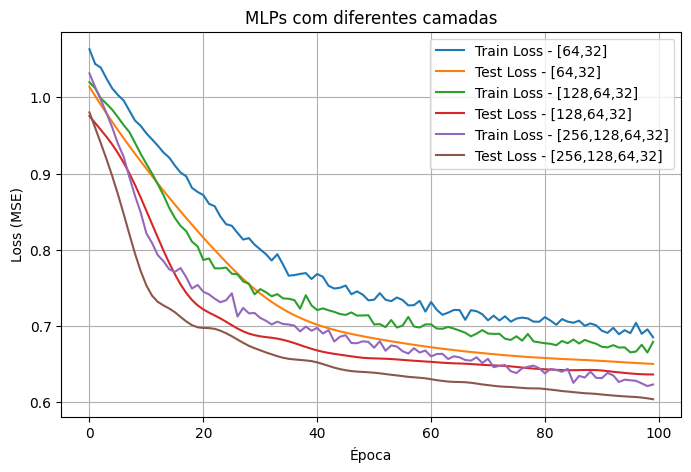

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss1, label='Train Loss - [64,32]')
plt.plot(test_loss1, label='Test Loss - [64,32]')
plt.plot(train_loss2, label='Train Loss - [128,64,32]')
plt.plot(test_loss2, label='Test Loss - [128,64,32]')
plt.plot(train_loss3, label='Train Loss - [256,128,64,32]')
plt.plot(test_loss3, label='Test Loss - [256,128,64,32]')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.title('MLPs com diferentes camadas')
plt.legend()
plt.grid(True)
plt.show()


#### Conclusões

Durante o treinamento, observou-se que a curva de perda no conjunto de treino apresentava oscilações, enquanto a perda n teste permaneceu baixa e estável.

Isso indica que o modelo consegue generalizar bem para dados não vistos.
As oscilações no treino podem estar relacionadas a taxa de aprendizado relativamente alta e a ausência de mecanismos como early stopping.

Apesar dessas oscilações, o modelo não sofreu overfitting, pois o erro no teste permaneceu consistente e não cresceu ao longo das épocas.


### Experimento 2 (early stopping)

In [ ]:
model1 = MLP(input_dim=input_dim,
    hidden_layers=[64, 32],
    output_dim=1,
    activation=nn.ReLU,
    dropout_rate=0.25
).to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.0005, weight_decay=1e-5)
epochs = 500
train_loss1, test_loss1 = train_model_early_stopping(
    model1, optimizer1, criterion,
    X_train, y_train, X_test, y_test,
    epochs=epochs
)


Train Loss = 0.6305, Test Loss = 0.6209, LR: 0.000500


In [ ]:
model2 = MLP(
    input_dim=input_dim,
    hidden_layers=[128, 64, 32],
    output_dim=1,
    activation=nn.ReLU,
    dropout_rate=0.25
).to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0005, weight_decay=1e-5)
epochs = 500
train_loss2, test_loss2 = train_model_early_stopping(
    model2, optimizer2, criterion,
    X_train, y_train, X_test, y_test,
    epochs=epochs
)

Train Loss = 0.5696, Test Loss = 0.5727, LR: 0.000250


In [ ]:
model3 = MLP(input_dim=input_dim,
    hidden_layers=[256, 128, 64, 32],
    output_dim=1,
    activation=nn.ReLU,
    dropout_rate=0.25
).to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.0005, weight_decay=1e-5)
epochs = 500
train_loss3, test_loss3 = train_model_early_stopping(
    model3, optimizer3, criterion,
    X_train, y_train, X_test, y_test,
    epochs=epochs
)

Early stopping at epoch 322
Train Loss = 0.5554, Test Loss = 0.5772, LR: 0.000063


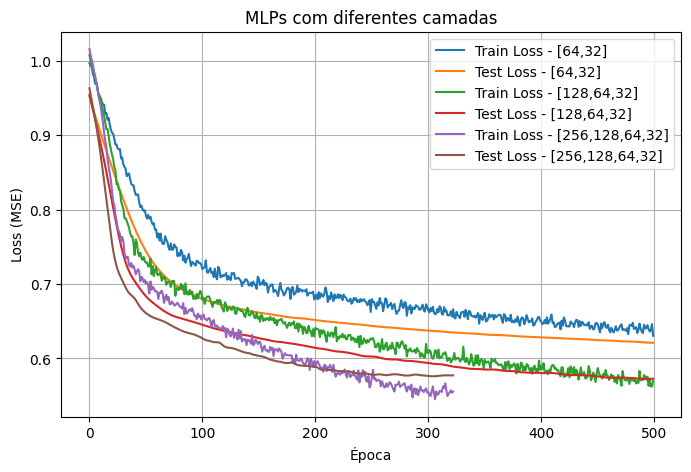

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss1, label='Train Loss - [64,32]')
plt.plot(test_loss1, label='Test Loss - [64,32]')
plt.plot(train_loss2, label='Train Loss - [128,64,32]')
plt.plot(test_loss2, label='Test Loss - [128,64,32]')
plt.plot(train_loss3, label='Train Loss - [256,128,64,32]')
plt.plot(test_loss3, label='Test Loss - [256,128,64,32]')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.title('MLPs com diferentes camadas')
plt.legend()
plt.grid(True)
plt.show()

#### Resultados

- Otimizador: Adam (lr=0.0005, weight_decay=1e-5)
- Dropout: 0.3
- Critério de parada: early stopping com `patience=20` e `min_delta=0.001`
- As arquiteturas menores não pararam e foram até o fim do experimento

Observações:
- O uso do early stopping impediu que o modelo continuasse treinando após atingir um platô.
- A diferença pequena entre treino e teste sugere boa generalização.

### Experimento 3 (Otimizador SGD com momentum)

In [ ]:
model1 = MLP(
    input_dim=input_dim,
    hidden_layers=[128, 64, 32],
    output_dim=1,
    activation=nn.ReLU,
    dropout_rate=0.25
).to(device)
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
epochs = 1000
train_loss1, test_loss21= train_model_early_stopping(
    model1, optimizer1, criterion,
    X_train, y_train, X_test, y_test,
    epochs=epochs
)

Early stopping at epoch 758
Train Loss = 0.6663, Test Loss = 0.6343, LR: 0.001250


In [ ]:
model2 = MLP(input_dim=input_dim,
    hidden_layers=[256, 128, 64, 32],
    output_dim=1,
    activation=nn.ReLU,
    dropout_rate=0.25
).to(device)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
epochs = 1000
train_loss2, test_loss2 = train_model_early_stopping(
    model2, optimizer2, criterion,
    X_train, y_train, X_test, y_test,
    epochs=epochs
)

Early stopping at epoch 774
Train Loss = 0.6253, Test Loss = 0.6103, LR: 0.001250


In [ ]:
model3 = MLP(input_dim=input_dim,
    hidden_layers=[512, 256, 128, 64, 32],
    output_dim=1,
    activation=nn.ReLU,
    dropout_rate=0.25
).to(device)
optimizer3 = torch.optim.SGD(model3.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
epochs = 1000
train_loss3, test_loss3 = train_model_early_stopping(
    model3, optimizer3, criterion,
    X_train, y_train, X_test, y_test,
    epochs=epochs
)

Early stopping at epoch 539
Train Loss = 0.6299, Test Loss = 0.6086, LR: 0.005000


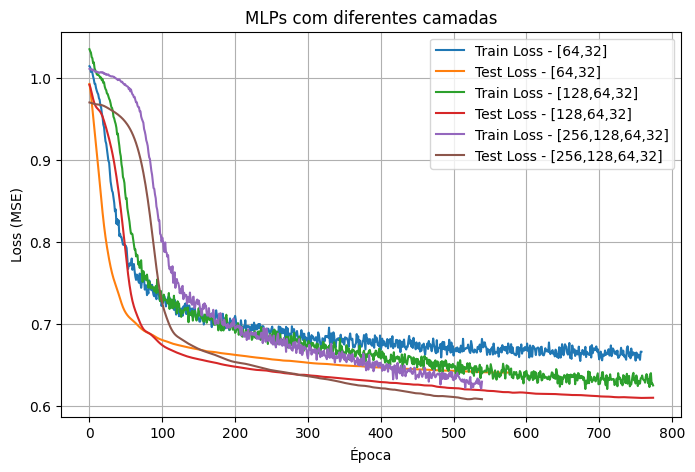

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss1, label='Train Loss - [64,32]')
plt.plot(test_loss1, label='Test Loss - [64,32]')
plt.plot(train_loss2, label='Train Loss - [128,64,32]')
plt.plot(test_loss2, label='Test Loss - [128,64,32]')
plt.plot(train_loss3, label='Train Loss - [256,128,64,32]')
plt.plot(test_loss3, label='Test Loss - [256,128,64,32]')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.title('MLPs com diferentes camadas')
plt.legend()
plt.grid(True)
plt.show()

#### Resultados

- O uso de momentum + SGD permitiu convergência, mas lenta. A learning rate final foi baixa.
- Os modelos com SGD precisaram de muito mais épocas para parar
- A learning rate caiu para valores baixos (0.00125) no final, o que pode ter freado o progresso final do treinamento.

### Experimento 4 (usando Optuna)

#### Melhores Hiperparâmetros encontrados:
- Número de camadas ocultas: 2
- Tamanho das camadas: [308, 120]
- Função de ativação: ReLU
- Taxa de dropout: 0.2052
- Taxa de aprendizado (lr): 0.00484
- Weight decay: 4.55 × 10⁻⁵

#### Parâmetros do early stopping
- epochs: 1000
- patience: 20
- min_delta: 1e-5

In [ ]:
model1 = MLP(
    input_dim=input_dim,
    hidden_layers=hidden_layers,
    output_dim=1,
    activation=activation_map[best_params["activation"]],
    dropout_rate=best_params["dropout_rate"],
    use_batchnorm=False
).to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])
epochs = 1000
train_loss1, test_loss1= train_model_early_stopping(
    model1, optimizer1, criterion,
    X_train, y_train, X_test, y_test,
    epochs=epochs
)

Early stopping at epoch 162
Train Loss = 0.4466, Test Loss = 0.5538, LR: 0.001211


#### Conclusões

- O optuna conseguiu escolher os melhores hiperparâmetros e obteve o melhor resultado nos treinos, mas não tão bem generalizados.
- É interessante testar flexibilizar o early stopping para tentar conseguir resultados ainda melhores

#### Parâmetros do early stopping
- epochs: 1500
- patience: 50
- min_delta = 1e-6

In [ ]:
model2 = MLP(
    input_dim=input_dim,
    hidden_layers=hidden_layers,
    output_dim=1,
    activation=activation_map[best_params["activation"]],
    dropout_rate=best_params["dropout_rate"]
).to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])
epochs = 1500
train_loss2, test_loss2= train_model_early_stopping(
    model1, optimizer1, criterion,
    X_train, y_train, X_test, y_test,
    epochs=epochs
)

Early stopping at epoch 131
Train Loss = 0.4197, Test Loss = 0.5450, LR: 0.000038


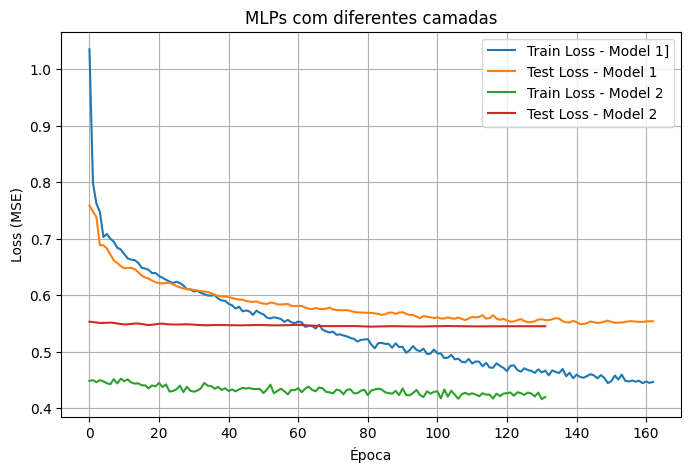

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss1, label='Train Loss - Model 1]')
plt.plot(test_loss1, label='Test Loss - Model 1')
plt.plot(train_loss2, label='Train Loss - Model 2')
plt.plot(test_loss2, label='Test Loss - Model 2')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.title('MLPs com diferentes camadas')
plt.legend()
plt.grid(True)
plt.show()

#### Conclusões

- A diferença entre treino e teste é significante, o que indica generalização razoável
- Resultados de treino ligeiramente superiores ao primeiro early stopping, teste se manteve
- A flexibilização do early stopping não fez o treino aumentar muito
- Testar adicionar batch normalization para maior regularização

### Experimento 5 (batch normalization)

In [ ]:
model1 = MLP(
    input_dim=input_dim,
    hidden_layers=hidden_layers,
    output_dim=1,
    activation=activation_map[best_params["activation"]],
    dropout_rate=best_params["dropout_rate"],
    use_batchnorm=True
).to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])
epochs = 1500
train_loss1, test_loss21= train_model_early_stopping(
    model1, optimizer1, criterion,
    X_train, y_train, X_test, y_test,
    epochs=epochs
)

Early stopping at epoch 83
Train Loss = 0.4069, Test Loss = 0.5778, LR: 0.002324


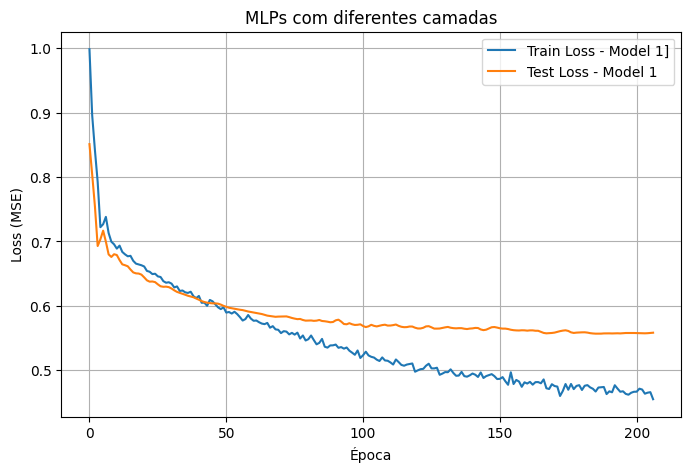

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss1, label='Train Loss - Model 1]')
plt.plot(test_loss1, label='Test Loss - Model 1')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.title('MLPs com diferentes camadas')
plt.legend()
plt.grid(True)
plt.show()

#### Conclusões

- Train loss muito baixa, mas a test loss maior que experimentos passados. A diferença entre as duas indica overfitting.
- Poucas epochs, o treinamento parou cedo demais.
- BatchNorm deve ter acelerado demais o treinamento

# CNN

## Configurações e Base de Dados

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 23.6 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print("Dispositivo atual:", device)
print("CUDA disponível:", torch.cuda.is_available())




Dispositivo atual: cuda
CUDA disponível: True


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])


In [ ]:
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


100%|██████████| 170M/170M [00:02<00:00, 66.0MB/s]


In [ ]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
class_names = trainset.classes

In [ ]:
images, labels = next(iter(trainloader))
print(images.shape)
print(labels)


torch.Size([128, 3, 32, 32])
tensor([8, 5, 3, 7, 9, 1, 4, 0, 0, 9, 4, 2, 3, 4, 4, 7, 1, 8, 3, 2, 9, 5, 4, 3,
        0, 3, 7, 2, 7, 1, 6, 7, 7, 4, 9, 6, 8, 8, 9, 3, 0, 5, 6, 6, 1, 9, 2, 8,
        4, 0, 9, 8, 3, 8, 1, 5, 4, 7, 3, 5, 7, 0, 5, 9, 0, 1, 4, 1, 9, 9, 2, 1,
        2, 3, 2, 6, 3, 2, 5, 1, 3, 1, 0, 8, 2, 6, 7, 1, 4, 5, 8, 8, 4, 0, 8, 6,
        0, 4, 6, 0, 9, 7, 7, 0, 1, 2, 9, 0, 7, 9, 3, 2, 3, 4, 8, 7, 9, 0, 3, 4,
        2, 4, 2, 4, 8, 4, 4, 7])


## Modelo

In [ ]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, conv_channels, activation=nn.ReLU, dropout_rate=0.3, num_classes=10):
        super(CNN, self).__init__()

        layers = []
        in_channels = 3

        for out_channels in conv_channels:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(activation())
            layers.append(nn.MaxPool2d(2))
            in_channels = out_channels

        self.conv_block = nn.Sequential(*layers)

        # 32x32 -> 16x16 -> 8x8 -> 4x4
        final_size = 32 // (2 ** len(conv_channels))
        flattened_size = conv_channels[-1] * final_size * final_size

        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            activation(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x



In [ ]:
criterion = nn.CrossEntropyLoss()


## Optuna

In [ ]:
import optuna
import torch.nn.functional as F

def define_model(trial):
    n_filters1 = trial.suggest_categorical("n_filters1", [16, 32, 64])
    n_filters2 = trial.suggest_categorical("n_filters2", [32, 64, 128])
    n_filters3 = trial.suggest_categorical("n_filters3", [64, 128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    class CNNOptuna(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv_block = nn.Sequential(
                nn.Conv2d(3, n_filters1, kernel_size=3, padding=1),
                nn.BatchNorm2d(n_filters1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(n_filters1, n_filters2, kernel_size=3, padding=1),
                nn.BatchNorm2d(n_filters2),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(n_filters2, n_filters3, kernel_size=3, padding=1),
                nn.BatchNorm2d(n_filters3),
                nn.ReLU(),
                nn.MaxPool2d(2),
            )
            self.fc_block = nn.Sequential(
                nn.Flatten(),
                nn.Linear(n_filters3 * 4 * 4, 128),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(128, 10)
            )

        def forward(self, x):
            x = self.conv_block(x)
            x = self.fc_block(x)
            return x

    model = CNNOptuna().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # subset menor pra acelerar
    trainloader_sub = DataLoader(train_subset, batch_size=64, shuffle=True)
    testloader_sub = DataLoader(test_subset, batch_size=64, shuffle=False)

    train_losses, test_losses, train_accs, test_accs = train_model_early_stopping_classification(
        model, optimizer, criterion,
        trainloader_sub, testloader_sub,
        device=device,
        epochs=15, patience=5
    )

    return 1.0 - test_accs[-1]


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(define_model, n_trials=20)
best_params = study.best_params
print(best_params)


[I 2025-06-30 12:25:24,863] A new study created in memory with name: no-name-f5383442-e9b7-4c6b-84bd-4ce37190169c
[I 2025-06-30 12:27:30,961] Trial 0 finished with value: 0.34199999999999997 and parameters: {'n_filters1': 32, 'n_filters2': 64, 'n_filters3': 256, 'dropout_rate': 0.4229815861925361, 'lr': 0.0002092506187239829, 'weight_decay': 2.5195825739061578e-05}. Best is trial 0 with value: 0.34199999999999997.


Final LR: 0.000209


[I 2025-06-30 12:29:35,825] Trial 1 finished with value: 0.3415 and parameters: {'n_filters1': 32, 'n_filters2': 128, 'n_filters3': 64, 'dropout_rate': 0.49823013972977115, 'lr': 0.0001340149919976552, 'weight_decay': 0.00014048204553100663}. Best is trial 1 with value: 0.3415.


Final LR: 0.000134


[I 2025-06-30 12:31:39,992] Trial 2 finished with value: 0.39 and parameters: {'n_filters1': 32, 'n_filters2': 32, 'n_filters3': 256, 'dropout_rate': 0.2327558323488046, 'lr': 0.0026853172531803187, 'weight_decay': 1.887793344082188e-05}. Best is trial 1 with value: 0.3415.


Final LR: 0.002685


[I 2025-06-30 12:33:48,598] Trial 3 finished with value: 0.376 and parameters: {'n_filters1': 64, 'n_filters2': 32, 'n_filters3': 256, 'dropout_rate': 0.17207146762466669, 'lr': 0.0035031692465769134, 'weight_decay': 0.0005949381918358363}. Best is trial 1 with value: 0.3415.


Final LR: 0.003503


[I 2025-06-30 12:35:50,874] Trial 4 finished with value: 0.28800000000000003 and parameters: {'n_filters1': 32, 'n_filters2': 64, 'n_filters3': 64, 'dropout_rate': 0.12831771233016928, 'lr': 0.0008345387132825702, 'weight_decay': 5.590399893224136e-05}. Best is trial 4 with value: 0.28800000000000003.


Final LR: 0.000835


[I 2025-06-30 12:37:56,913] Trial 5 finished with value: 0.4655 and parameters: {'n_filters1': 64, 'n_filters2': 64, 'n_filters3': 128, 'dropout_rate': 0.191150503367721, 'lr': 0.009409612429829354, 'weight_decay': 0.0006206713449984944}. Best is trial 4 with value: 0.28800000000000003.


Final LR: 0.009410


[I 2025-06-30 12:40:05,394] Trial 6 finished with value: 0.31299999999999994 and parameters: {'n_filters1': 64, 'n_filters2': 64, 'n_filters3': 256, 'dropout_rate': 0.39327262008797736, 'lr': 0.0004717849322528526, 'weight_decay': 1.6317902222371763e-05}. Best is trial 4 with value: 0.28800000000000003.


Final LR: 0.000472


[I 2025-06-30 12:42:07,977] Trial 7 finished with value: 0.48550000000000004 and parameters: {'n_filters1': 16, 'n_filters2': 32, 'n_filters3': 128, 'dropout_rate': 0.21352900892297352, 'lr': 0.006280644646051898, 'weight_decay': 3.0781704568001315e-06}. Best is trial 4 with value: 0.28800000000000003.


Final LR: 0.006281


[I 2025-06-30 12:44:12,256] Trial 8 finished with value: 0.361 and parameters: {'n_filters1': 16, 'n_filters2': 64, 'n_filters3': 256, 'dropout_rate': 0.39503717533952243, 'lr': 0.00019831645731886247, 'weight_decay': 1.879306330070318e-05}. Best is trial 4 with value: 0.28800000000000003.


Final LR: 0.000198


[I 2025-06-30 12:46:17,568] Trial 9 finished with value: 0.37749999999999995 and parameters: {'n_filters1': 16, 'n_filters2': 128, 'n_filters3': 128, 'dropout_rate': 0.45396007695138274, 'lr': 0.00181624373977377, 'weight_decay': 2.3497842920232237e-06}. Best is trial 4 with value: 0.28800000000000003.


Final LR: 0.001816


[I 2025-06-30 12:48:18,886] Trial 10 finished with value: 0.32999999999999996 and parameters: {'n_filters1': 32, 'n_filters2': 64, 'n_filters3': 64, 'dropout_rate': 0.10475003519782419, 'lr': 0.0007325682719355949, 'weight_decay': 8.862926044083435e-05}. Best is trial 4 with value: 0.28800000000000003.


Final LR: 0.000733


[I 2025-06-30 12:50:22,915] Trial 11 finished with value: 0.3045 and parameters: {'n_filters1': 64, 'n_filters2': 64, 'n_filters3': 64, 'dropout_rate': 0.3204636169085181, 'lr': 0.0006232736158782468, 'weight_decay': 7.654266732289576e-06}. Best is trial 4 with value: 0.28800000000000003.


Final LR: 0.000623


[I 2025-06-30 12:52:26,897] Trial 12 finished with value: 0.34450000000000003 and parameters: {'n_filters1': 64, 'n_filters2': 64, 'n_filters3': 64, 'dropout_rate': 0.3165867227041393, 'lr': 0.0010376858290579534, 'weight_decay': 5.757203603023656e-06}. Best is trial 4 with value: 0.28800000000000003.


Final LR: 0.001038


[I 2025-06-30 12:54:31,454] Trial 13 finished with value: 0.30100000000000005 and parameters: {'n_filters1': 64, 'n_filters2': 64, 'n_filters3': 64, 'dropout_rate': 0.3008646206285659, 'lr': 0.0003823697621139482, 'weight_decay': 9.387452047510444e-05}. Best is trial 4 with value: 0.28800000000000003.


Final LR: 0.000382


[I 2025-06-30 12:56:33,200] Trial 14 finished with value: 0.3285 and parameters: {'n_filters1': 32, 'n_filters2': 64, 'n_filters3': 64, 'dropout_rate': 0.28895445914894213, 'lr': 0.0003396061488145178, 'weight_decay': 9.730393734754515e-05}. Best is trial 4 with value: 0.28800000000000003.


Final LR: 0.000340


[I 2025-06-30 12:58:41,469] Trial 15 finished with value: 0.2955 and parameters: {'n_filters1': 64, 'n_filters2': 128, 'n_filters3': 64, 'dropout_rate': 0.2674925139717452, 'lr': 0.001304119677072349, 'weight_decay': 0.00022538494566955072}. Best is trial 4 with value: 0.28800000000000003.


Final LR: 0.001304


[I 2025-06-30 13:00:45,952] Trial 16 finished with value: 0.3345 and parameters: {'n_filters1': 32, 'n_filters2': 128, 'n_filters3': 64, 'dropout_rate': 0.11881631015371741, 'lr': 0.0013256157608460778, 'weight_decay': 0.0002632400189475885}. Best is trial 4 with value: 0.28800000000000003.


Final LR: 0.001326


[I 2025-06-30 13:02:52,138] Trial 17 finished with value: 0.2935 and parameters: {'n_filters1': 64, 'n_filters2': 128, 'n_filters3': 64, 'dropout_rate': 0.1508164796391185, 'lr': 0.0017057694352591464, 'weight_decay': 0.0002308162181172262}. Best is trial 4 with value: 0.28800000000000003.


Final LR: 0.001706


[I 2025-06-30 13:04:55,394] Trial 18 finished with value: 0.32599999999999996 and parameters: {'n_filters1': 32, 'n_filters2': 128, 'n_filters3': 64, 'dropout_rate': 0.1503992030455569, 'lr': 0.0029057467015979853, 'weight_decay': 5.532887101967626e-05}. Best is trial 4 with value: 0.28800000000000003.


Final LR: 0.002906


[I 2025-06-30 13:06:58,617] Trial 19 finished with value: 0.3135 and parameters: {'n_filters1': 16, 'n_filters2': 128, 'n_filters3': 64, 'dropout_rate': 0.15457157224786988, 'lr': 0.002107016047288852, 'weight_decay': 4.747977325777766e-05}. Best is trial 4 with value: 0.28800000000000003.


Final LR: 0.002107
{'n_filters1': 32, 'n_filters2': 64, 'n_filters3': 64, 'dropout_rate': 0.12831771233016928, 'lr': 0.0008345387132825702, 'weight_decay': 5.590399893224136e-05}


## Treino

In [ ]:
def train_model_early_stopping_classification(
    model, optimizer, criterion,
    train_loader, test_loader,
    device,
    epochs=1000, patience=50, min_delta=1e-7
):
    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10,
    )

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_loss /= total
        test_acc = correct / total

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # early stopping
        scheduler.step(test_loss)
        if best_loss - test_loss > min_delta:
            best_loss = test_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    if best_model_state:
        model.load_state_dict(best_model_state)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Final LR: {current_lr:.6f}")

    return train_losses, test_losses, train_accuracies, test_accuracies


In [ ]:
import torch.nn.functional as F

def train_cnn_with_optuna_params(
    params,
    train_loader,
    test_loader,
    device,
    epochs=150,
    patience=15,
    min_delta=1e-5
):
    class CNN_Optuna(nn.Module):
        def __init__(self, params):
            super().__init__()
            self.conv_block = nn.Sequential(
                nn.Conv2d(3, params['n_filters1'], kernel_size=3, padding=1),
                nn.BatchNorm2d(params['n_filters1']),
                nn.ReLU(),
                nn.MaxPool2d(2),

                nn.Conv2d(params['n_filters1'], params['n_filters2'], kernel_size=3, padding=1),
                nn.BatchNorm2d(params['n_filters2']),
                nn.ReLU(),
                nn.MaxPool2d(2),

                nn.Conv2d(params['n_filters2'], params['n_filters3'], kernel_size=3, padding=1),
                nn.BatchNorm2d(params['n_filters3']),
                nn.ReLU(),
                nn.MaxPool2d(2),
            )

            self.fc_block = nn.Sequential(
                nn.Flatten(),
                nn.Linear(params['n_filters3'] * 4 * 4, 128),
                nn.ReLU(),
                nn.Dropout(params['dropout_rate']),
                nn.Linear(128, 10)
            )

        def forward(self, x):
            x = self.conv_block(x)
            x = self.fc_block(x)
            return x

    model = CNN_Optuna(params).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=params['lr'],
        weight_decay=params['weight_decay']
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )


    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total


        model.eval()
        test_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_loss /= total
        test_acc = correct / total

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        scheduler.step(test_loss)

        if epoch % 10 == 0 or epoch == epochs - 1:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
                  f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, LR: {current_lr:.6f}")

        if best_loss - test_loss > min_delta:
            best_loss = test_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    if best_model_state:
        model.load_state_dict(best_model_state)

    final_lr = optimizer.param_groups[0]['lr']
    print(f"Final LR: {final_lr:.6f}")
    return model, train_losses, test_losses, train_accs, test_accs


In [ ]:
activation_map = {
    "ReLU": nn.ReLU,
    "LeakyReLU": nn.LeakyReLU,
    "ELU": nn.ELU,
    "Tanh": nn.Tanh,
    "Sigmoid": nn.Sigmoid
}

## Métricas

In [ ]:
def tempo_treinamento(func, *args, **kwargs):
    import time
    inicio = time.time()
    resultados = func(*args, **kwargs)
    fim = time.time()
    duracao = fim - inicio
    print(f"Tempo total de treinamento: {duracao:.2f} segundos")
    return resultados, duracao


In [ ]:
def plot_metricas(train_losses, test_losses, train_accs, test_accs):
    import matplotlib.pyplot as plt
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.title('Loss por Época')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, test_accs, label='Test Accuracy')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.title('Acurácia por Época')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def matriz_confusao(model, dataloader, device, class_names=None):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import torch

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')
    plt.show()


## Experimentos

### Experimento 1

- Filtros por camada: [32, 64, 128]
- Loss: Cross Entropy
- Otimizador: Adam
- Learning Rate: 0.001
- Weight Decay: 1e-4
- Epochs: 100
- Early Stopping Patience: 15
- min_delta (early stop): 1e-7
- Scheduler: `ReduceLROnPlateau (factor=0.5, patience=10)`
- Dropout: 0.3
- Batch Size: 64

In [ ]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

train_losses, test_losses, train_accs, test_accs = train_model_early_stopping_classification(
    model, optimizer, criterion,
    trainloader, testloader,
    device=device,
    epochs=100, patience=15
)


Early stopping at epoch 23
Final LR: 0.000500


In [ ]:
print(next(model.parameters()).device)

cuda:0


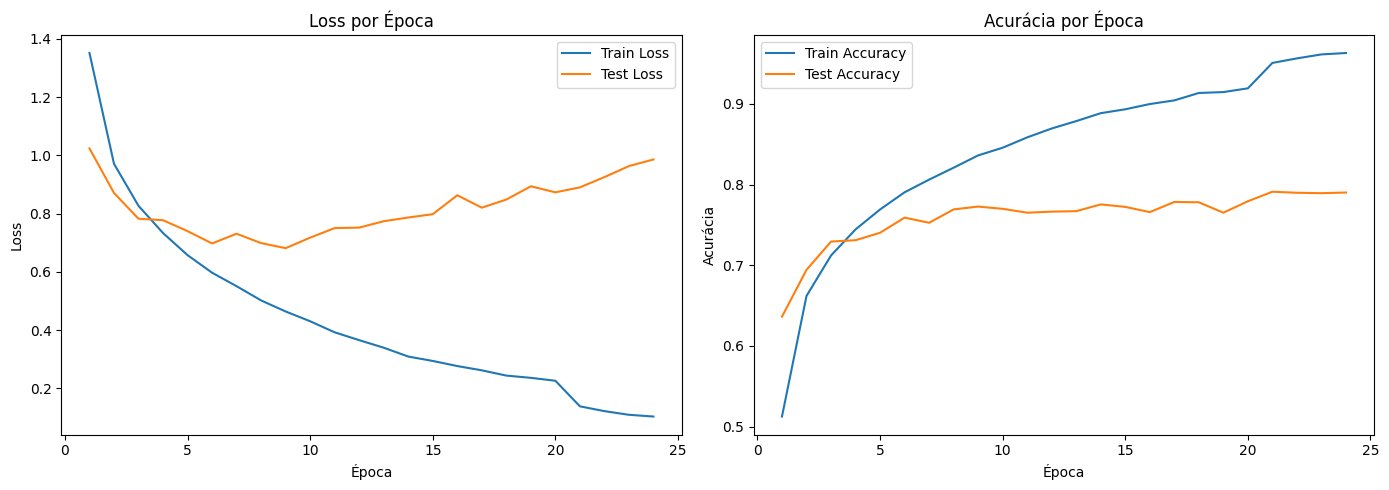

In [ ]:
plot_metricas(train_losses, test_losses, train_accs, test_accs)

In [ ]:
print(train_losses, test_losses, train_accs, test_accs)

[1.3509450384902955, 0.9707934751319885, 0.8265081922149659, 0.7332139617919922, 0.6574030755996704, 0.597138669090271, 0.550807737159729, 0.501971962852478, 0.46410524797439573, 0.4305305197286606, 0.3925604391860962, 0.3657222436237335, 0.339791752576828, 0.309497615942955, 0.29435644376277925, 0.2768427012825012, 0.26221688327789305, 0.2441496183490753, 0.23640206057071686, 0.22641217987060547, 0.1386842943239212, 0.12215306970000267, 0.10965913238286971, 0.10363092966735363] [1.0236410442352295, 0.8706276517868042, 0.782335544204712, 0.7773179859161377, 0.7397485721588135, 0.6975916973114014, 0.7308633861541748, 0.6987353138923645, 0.6813753282546997, 0.7175011390686035, 0.7502747241973877, 0.7519266317367553, 0.7737727827072144, 0.7865543656349182, 0.7979719168663025, 0.862872497177124, 0.8202786118507385, 0.8482172740936279, 0.8936399191856385, 0.8729623643875122, 0.8900120655059814, 0.925174098110199, 0.9630395931243897, 0.9856784568786621] [0.51242, 0.66198, 0.71214, 0.74446, 0

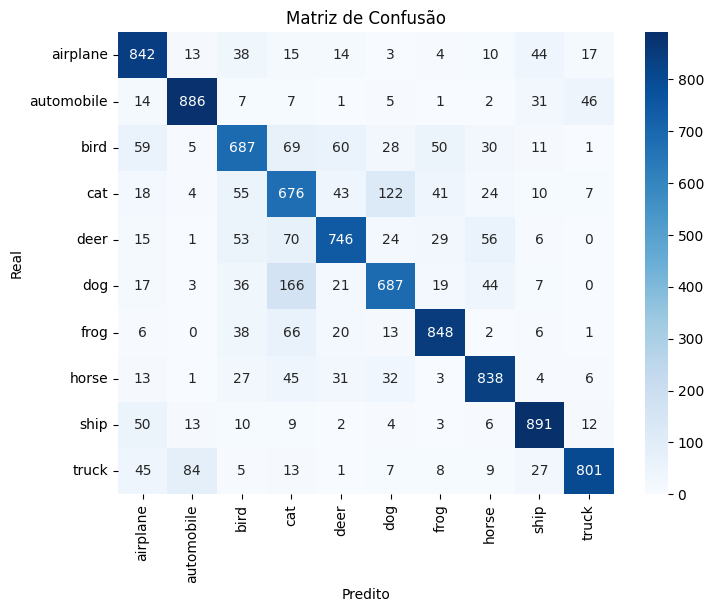

In [ ]:
matriz_confusao(model, testloader, device, class_names)

#### Conclusões

- Loss: No treino apresentou uma queda contínua, o que indica que os padrões de treino foram bem aprendidos. Já no teste, houve uma pequena queda, mas que foi seguida por uma subida, terminando próximo ao valor de início, indicando overfitting do modelo.

- Acurácia: No teste começou em 51,2% e chegou a 96.3%, mostrando que o modelo conseguiu memorizar bem o conjunto de treino. No conjunto de teste, começou com 63,6% e se estabilizou próximo aos 80%. Sendo assim, o modelo apresentou uma boa capacidade de generalização inicial, mas tendendo a saturar antes do final do treinamento.

- Overfitting: A diferença entre as Loss de treino e teste foi crescente e é um forte indicativo de overfitting.

- Próximos passos: Testar a capacidade de melhora do modelo apenas com a melhora dos hiperparâmetros e maior complexidade de arquitetura.

### Experimento 2 (Optuna)

- Filtros por camada: [64, 128, 256]
- Loss: Cross Entropy
- Otimizador: Adam
- Learning Rate: 0.000764
- Weight Decay: 6.474325013417402e-05
- Epochs: 150
- Early Stopping Patience: 15
- min_delta (early stop): 1e-7
- Dropout:  0.4234064068675336

In [ ]:
model, train_losses, test_losses, train_accs, test_accs = train_cnn_with_optuna_params(
    best_params,
    train_loader=trainloader,
    test_loader=testloader,
    device=device,
    epochs=150,
    patience=15
)

Early stopping at epoch 24
Final LR: 0.000221


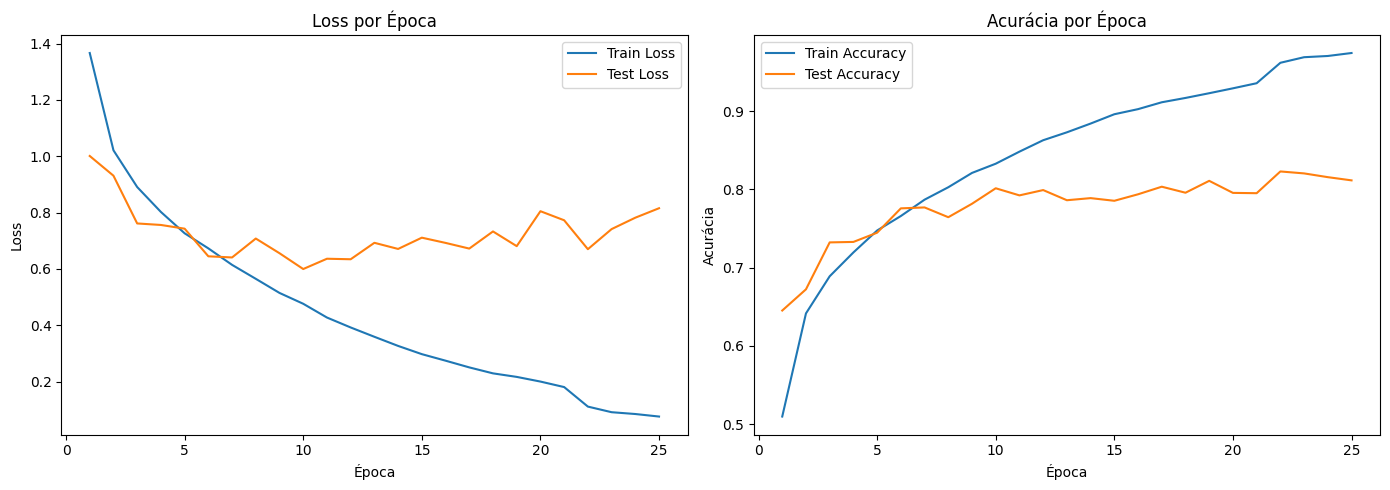

In [ ]:
plot_metricas(train_losses, test_losses, train_accs, test_accs)

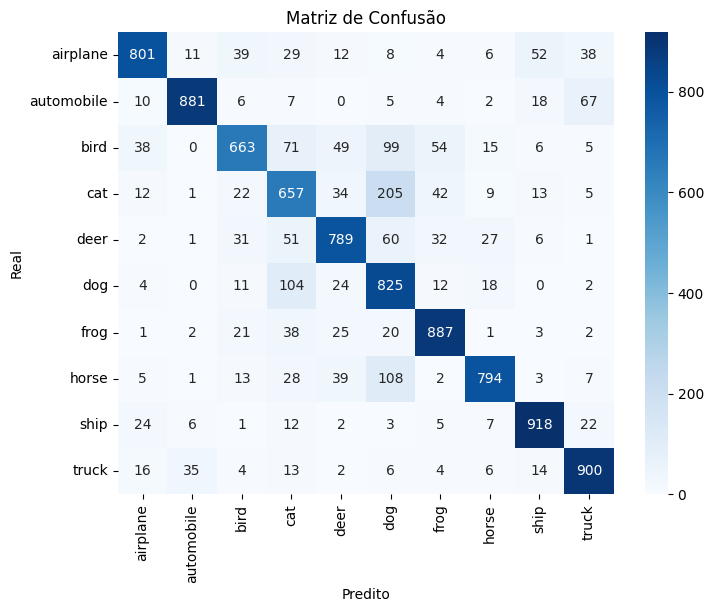

In [ ]:
matriz_confusao(model, testloader, device, class_names)

In [ ]:
print(train_losses, test_losses, train_accs, test_accs)

[1.3663697093582152, 1.0210925154876709, 0.8907501185226441, 0.8023014508056641, 0.7265989967727661, 0.6730721012687683, 0.6145442291831971, 0.5650146215438843, 0.5149120455360413, 0.4764572023391724, 0.4276240357494354, 0.39236437368392946, 0.3592993268823624, 0.3268864035606384, 0.2976813771915436, 0.27452471053123473, 0.2506599008798599, 0.22948193354129792, 0.21696378921508788, 0.20036865750312804, 0.1808625120639801, 0.11156207415819168, 0.09165147603392601, 0.0852200132572651, 0.07624580673098565] [1.000929303741455, 0.9309365026473999, 0.7615001998901367, 0.756142038154602, 0.7429704723358155, 0.644906864976883, 0.640823442029953, 0.7079607666015625, 0.6558480069637299, 0.5997614827156067, 0.6362779487609863, 0.6344344043731689, 0.6928260943412781, 0.6710433863639832, 0.7110276834487915, 0.6924819640159607, 0.6723207753181457, 0.7331211003303528, 0.6809650179862976, 0.8049306035995484, 0.7728074646949769, 0.6701731736183166, 0.7414553347587586, 0.7819297015190124, 0.815543896198

#### Resultados e Conclusões

- Loss: No treinamento caiu rapidamente e de forma estável, mostrando um aprendizado progressivo. No teste, a melhora foi pequena e com oscilações.

- Acurácia: No treino teve um aumento expressivo, saindo de 50% para 97,4%. No teste, embora ainda tenha oscilações, especialmente nos últimos ciclos, conseguiu uma melhora em relação ao experimento anterior.

-Overfitting: As diferenças entre loss de treino e teste ainda se fazem presentes e continuam indicando que o modelo está se adequando ao conjunto de treino. A oscilação na loss de teste após a metade indica o início do overfitting e sugere que o early stopping agiu corretamente em finalizar o treinamento. O dropout de 0.42 e o uso de BatchNorm ajudaram na regularização, controlando o sobreajuste.

- Próximos passos: Como o refinamento e otimização dos hiperparâmetros não foi suficiente para melhorar a generalização do modelo, faz-se necessário o enriquecimento da base de dados utilizando a técnica de data augmentation.

### Experimento 3 (Data Augmentation)

- Filtros por camada: [32, 64, 64]
- Loss: Cross Entropy
- Otimizador: Adam
- Learning Rate: 0.0008345387132825702
- Weight Decay: 5.590399893224136e-05
- Epochs iniciais: 150
- Early Stopping Patience: 15
- min_delta (early stop): 1e-7
- Dropout: 0.12831771233016928





{'n_filters1': 32, 'n_filters2': 64, 'n_filters3': 64, 'dropout_rate': 0.12831771233016928, 'lr': 0.0008345387132825702, 'weight_decay': 5.590399893224136e-05}

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # espelhamento horizontal aleatório com probabilidade de 50%
    transforms.RandomCrop(32, padding=4),  # expande a imagem preenchendo com 4 pixels e realiza um corte aleatório de 32x32
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # aplica perturbações no brilho, contraste e saturação
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])


In [ ]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

# não modifica as imagens


In [ ]:
from torchvision.datasets import CIFAR10

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

class_names = train_dataset.classes

100%|██████████| 170M/170M [00:04<00:00, 42.1MB/s]


In [ ]:
model, train_losses, test_losses, train_accs, test_accs = train_cnn_with_optuna_params(
    best_params,
    train_loader=trainloader,
    test_loader=testloader,
    device=device,
    epochs=150,
    patience=15
)

Early stopping at epoch 148
Final LR: 0.000026


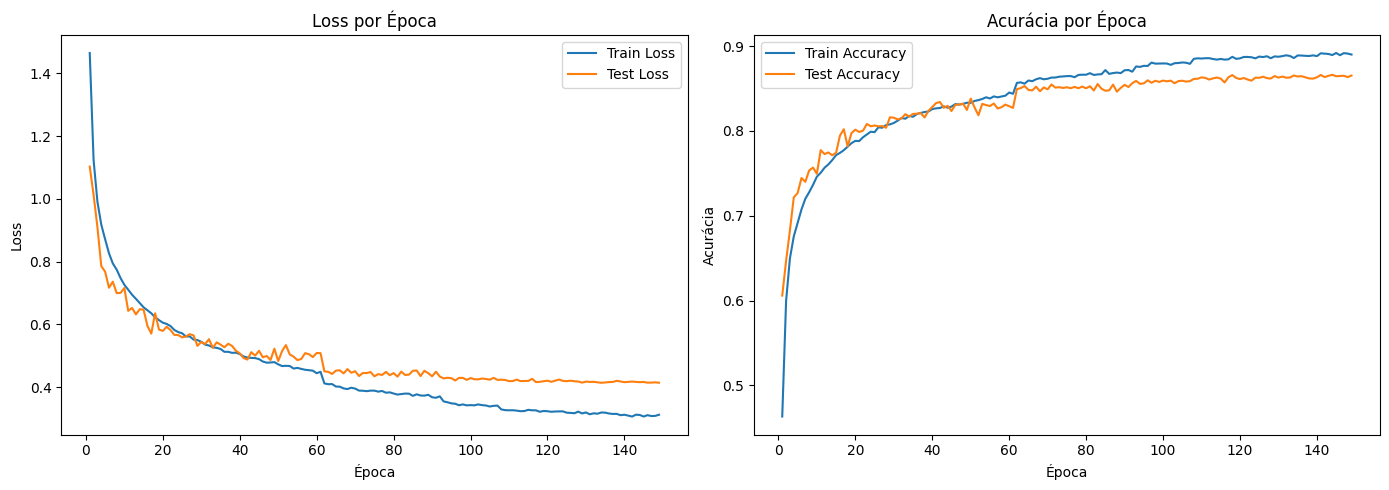

In [ ]:
plot_metricas(train_losses, test_losses, train_accs, test_accs)

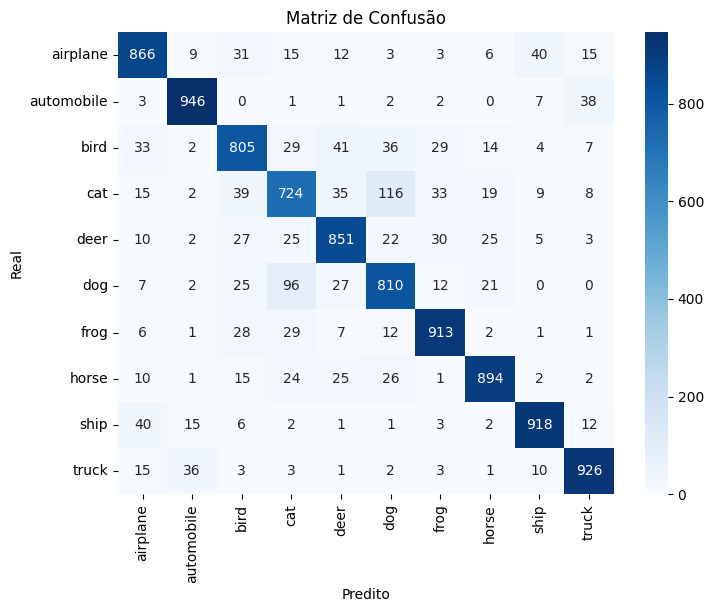

In [ ]:
matriz_confusao(model, testloader, device, class_names)

#### Resultados e Conclusões

- Loss: Teve grande queda em ambos os conjuntos e a diferença entre treino e teste foi reduzida drasticamente. Essa mudança mostrou que o overfitting foi reduzido significativamente e o modelo está aprendendo padrões mais robustos.

- Acurácia: O conjunto de teste conseguiu acompanhar o treino e se estabilizar sem apresentar uma queda, mostrando que o early stopping agiu corretamente.

- Data Augmentation: A otimização dos hiperparâmetros trouxe ganhos importantes, mas não suficientes para controlar o overfitting. A modificação e ampliação do conjunto de dados se mostrou fundamental para que o modelo consiga generalizar bem e aprender padrões complexos.

- Matriz de Confusão: Bons resultados com destaque para automobile (946) e truck (926). Maiores confusões continuam sendo entre cat e dog, com cat sendo classificada como dog 116 vezes e o inverso acontecendo 96 vezes.
